In [1]:
import gymnasium as gym
import numpy as np

def make_env(env_id, idx, capture_video, run_name, gamma):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        
        env = gym.wrappers.FlattenObservation(env)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        env = gym.wrappers.NormalizeObservation(env)
        env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10), observation_space=env.observation_space)
        env = gym.wrappers.NormalizeReward(env, gamma=gamma)
        env = gym.wrappers.TransformReward(env, lambda reward: np.clip(np.array(reward), -10, 10))
        return env
    
    return thunk

In [2]:
import random

import torch


seed = 1
torch_deterministic = True

# Scale up environments for better parallelization
num_envs = 128  # Increase from 16 to 64 or even 128
num_steps = 2048
num_minibatches = 32
total_timesteps = 20_000_000  # Increase from 5M to 20M for more training
update_epochs = 3

batch_size = int(num_envs * num_steps)
minibatch_size = batch_size // num_minibatches
num_iterations = total_timesteps // batch_size


random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#env_id = "LunarLanderContinuous-v3"
env_id = "HalfCheetah-v4"
capture_video = False
run_name = f"{env_id}__{seed}"
gamma = 0.99


# Use AsyncVectorEnv for better parallelization
envs = gym.vector.AsyncVectorEnv(
    [make_env(env_id, i, capture_video, run_name, gamma) for i in range(num_envs)]
)

assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

/home/ejcv/Documents/repos/dirtyRL/.venv/lib/python3.13/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


In [3]:
from torch import nn

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer




class Agent(nn.Module):
    def __init__(self, envs: gym.vector.VectorEnv):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(
                nn.Linear(64, np.array(envs.single_action_space.shape).prod()), std=0.01
            ),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)
    
    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)

        probs = torch.distributions.Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

In [4]:

learning_rate = 3e-4

agent = Agent(envs).to(device)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)


In [5]:
import time

# ALGO Logic: Storage setup


obs = torch.zeros((num_steps, num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((num_steps, num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((num_steps, num_envs)).to(device)
rewards = torch.zeros((num_steps, num_envs)).to(device)
dones = torch.zeros((num_steps, num_envs)).to(device)
values = torch.zeros((num_steps, num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(num_envs).to(device)

anneal_lr = True
gae_lambda = 0.95

clip_coef = 0.2
norm_adv = True
clip_vloss = True
ent_coef = 0.0
vf_coef = 0.5
max_grad_norm = 0.5
target_kl = None

for iteration in range(1, num_iterations + 1):
    if anneal_lr:
        frac = 1.0 - (iteration - 1.0) / num_iterations
        lrnow = frac * learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, num_steps):
        global_step += num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    print(
                        f"global_step={global_step}, episodic_return={info['episode']['r']}"
                    )

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # optimizing the policy and value network
    b_inds = np.arange(batch_size)
    clipfracs = []
    for epoch in range(update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(
                b_obs[mb_inds], b_actions[mb_inds]
            )

            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds], -clip_coef, clip_coef
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            optimizer.step()

        if target_kl is not None and approx_kl > target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    print("SPS:", int(global_step / (time.time() - start_time)), "explained_var:", explained_var)


    



SPS: 47201 explained_var: -0.2973634
SPS: 43960 explained_var: -0.12793767
SPS: 43960 explained_var: -0.12793767
SPS: 42537 explained_var: 0.09072763
SPS: 42537 explained_var: 0.09072763
SPS: 41706 explained_var: 0.14623433
SPS: 41706 explained_var: 0.14623433
SPS: 41279 explained_var: 0.20478731
SPS: 41279 explained_var: 0.20478731
SPS: 41058 explained_var: 0.22090453
SPS: 41058 explained_var: 0.22090453
SPS: 40837 explained_var: 0.21884876
SPS: 40837 explained_var: 0.21884876
SPS: 40682 explained_var: 0.21302962
SPS: 40682 explained_var: 0.21302962
SPS: 40533 explained_var: 0.19769412
SPS: 40533 explained_var: 0.19769412
SPS: 40466 explained_var: 0.18570095
SPS: 40466 explained_var: 0.18570095
SPS: 40378 explained_var: 0.20402992
SPS: 40378 explained_var: 0.20402992
SPS: 40301 explained_var: 0.21342099
SPS: 40301 explained_var: 0.21342099
SPS: 40236 explained_var: 0.24094194
SPS: 40236 explained_var: 0.24094194
SPS: 40177 explained_var: 0.2630762
SPS: 40177 explained_var: 0.2630762
S

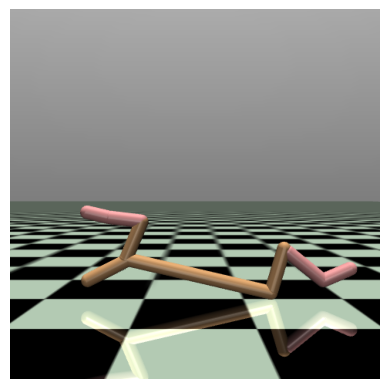

In [7]:
# run it over a test environment and render the results
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


test_env = gym.make(env_id, render_mode="rgb_array")
obs, _ = test_env.reset()
done = False
while not done:
    obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
    with torch.no_grad():
        action, _, _, _ = agent.get_action_and_value(obs_tensor)
    obs, reward, terminated, truncated, info = test_env.step(action.cpu().numpy()[0])
    done = terminated or truncated

    frame = test_env.render()
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis("off")
    plt.show()

    if done or truncated:
        obs, _ = test_env.reset()

